# Extended Numerical Example with loop
Here we extend the numerical example.

We will price a 1-year option with monthly exercise possibilities.

We will also use a strike of 1 instead of 1.1.

We will simulate our own stock price process using a geometric Brownian motion model.  
We assume a complete market with a risk-free interest rate of 5% and a stock volatility of 20%.

The dynamics of the stock price $S_t$ is given by the following solution:

$$
S_{t} = S_{0} \exp\left( \left(r_{f} - \frac{1}{2} \sigma^2\right)t + \sigma W_{t} \right)
$$

where $S_0$ is the initial stock price, $r_f$ is the risk-free interest rate, $\sigma$ is the volatility, and $W_t$ is a standard Brownian motion.


In [20]:
# Set the initial variables for the script
import numpy as np

# Define parameters
r = 0.06    # Interest rate
K = 1.00    # Strike price
# it is better to work in time-steps than in years
dt = 1/12   # Time-step size in years
nt = 12     # Number of time-steps
T = nt*dt   # Total time to maturity in years

N = 20      # Number of stock price paths to simulate

# For the stock price, here, we will simulate from a Geometric Brownian motion
# We assume a risk-neutral measure
S0 = 1.00   # Initial stock price
sigma = 0.2  # Volatility of the stock
# Generate the stock price paths
np.random.seed(42)  # For reproducibility
# It is possible to simulate from a Geometric Brownian motion without using a loop
# How ever, for clarity, we will use a loop here
S = np.zeros((N, nt + 1))
S[:, 0] = S0
for i in range(1, nt + 1):
    Z = np.random.normal(0, 1, N)  # Standard normal random variables
    S[:, i] = S[:, i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    


print("S matrix:\n", S)



S matrix:
 [[1.         1.03252901 1.12745597 1.18049337 1.15211647 1.14139504
  1.05534539 1.10834918 1.12675004 1.0686514  1.11165927 1.13865066
  1.30579773]
 [1.         0.99536143 0.98575126 0.99887669 0.99152647 1.01556144
  0.99450413 0.94678693 1.02441329 1.07561838 1.0271018  1.06444261
  0.9588487 ]
 [1.         1.04156839 1.0491284  1.04562637 0.98420128 1.07544523
  1.05789538 1.15097009 1.05246011 1.12902595 1.06487838 1.13737608
  1.18729606]
 [1.         1.09555984 1.01241743 0.99829153 0.93478416 0.9102567
  0.87195732 0.8068501  0.81821986 0.78296054 0.80776501 0.86130253
  0.78734691]
 [1.         0.98986618 0.96244136 0.88664437 0.93233156 0.8927829
  0.88746132 0.92111093 0.93815779 0.99512866 0.98565238 0.91333003
  0.89174804]
 [1.         0.98986712 0.99955298 0.96206428 1.0438981  1.01747723
  1.04496927 1.1898019  1.24889445 1.283286   1.34175726 1.27528301
  1.36256922]
 [1.         1.09911931 1.03188777 1.00816138 1.00733082 1.06554689
  1.19210483 1.12960182

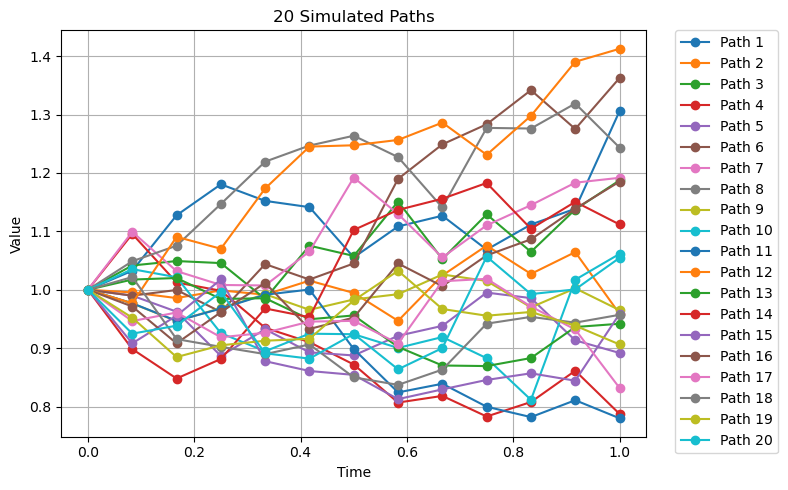

In [21]:
import matplotlib.pyplot as plt

# Now plot the simulated paths if we want too
times = np.linspace(0, T, nt + 1)

plt.figure(figsize=(8, 5))
for i in range(S.shape[0]):
    plt.plot(times, S[i], marker='o', label=f'Path {i+1}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'{S.shape[0]} Simulated Paths')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

In [22]:
# Initiate the backward algorithm and calculate the option payoff (exercise/intrinsic value), conditional on not exercising prior

# We will calculate the exercise/intrinsic value for each path at maturity
# recall that the option to price is a put option
intrinsic = np.maximum(K - S[:,-1], 0)

# We create a payoff vector that will contain the discounted exercise value.
payoff = np.copy(intrinsic)

# Assuming payoff is a 2D NumPy array
print(np.array2string(payoff, formatter={'float_kind':lambda x: f"{x:.4f}"}))


[0.0000 0.0412 0.0000 0.2127 0.1083 0.0000 0.0000 0.0000 0.0349 0.0000
 0.2200 0.0000 0.0582 0.0000 0.0413 0.0000 0.1681 0.0429 0.0937 0.0000]


In [23]:
# Now we set the vector exec_t to maturity for each path
exec_t = nt * np.ones((N,), dtype=int)  # All paths would optimally be exercised at time-step 3 (so far))

In [24]:
# Now, we can start the backward algorithm at t=T-1=2, and loop all the way back to t=1

# STEP 1	Discount the cash flows to time "t" based on when it's optimal to exercise for each path
# STEP 2	Identify the ITM paths in order toregress only on ITM paths
# STEP 3	Build X matrix for regression
# STEP 4	build y vector
# STEP 5	regress to get beta
# STEP 6	Calculate y_hat to approximate the holding value function
# STEP 7	Update the optimal exercise time for each path


for t_now in range(nt-1, 0, -1):

    # STEP 1
    dcf = np.exp(-r * dt) * payoff  # Discounted cash flow to time t
    print("Discounted Cash Flows (DCF):\n", np.array2string(dcf, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # STEP 2
    itm_paths = np.where(S[:, t_now] < K)[0]  # Identify ITM paths
    print("In-the-money paths at time t_now:\n", itm_paths)

    # STEP 3
    # Build X matrix for regression (using the stock prices at time t_now)
    # We use a constant, the stock price and the square of the stock price
    X = np.column_stack((np.ones(len(itm_paths)), S[itm_paths, t_now], S[itm_paths, t_now]**2))
    print("X matrix for regression:\n", np.array2string(X, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # STEP 4
    # Build y vector (the discounted cash flows for ITM paths)
    y = dcf[itm_paths]
    print("y vector for regression:\n", np.array2string(y, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # STEP 5
    # Perform regression to get beta coefficients
    from numpy.linalg import lstsq
    beta = lstsq(X, y, rcond=None)[0]
    print("Beta coefficients:\n", np.array2string(beta, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # STEP 6
    # Calculate y_hat to approximate the holding value function
    y_hat = X @ beta
    print("y_hat (holding value function):\n", np.array2string(y_hat, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # Update the payoff for exercised paths to be the current intrinsic value
    intrinsic[itm_paths] = np.maximum(K - S[itm_paths, t_now], 0)
    # print intrinsic for ITM paths
    print("Intrinsic value for ITM paths:\n", np.array2string(intrinsic[itm_paths], formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # STEP 7
    # Update the optimal exercise time for each path
    exec_t[itm_paths] = np.where(y_hat < intrinsic[itm_paths], t_now, exec_t[itm_paths])
    payoff = np.where(exec_t == t_now, intrinsic, dcf)


    # Print the updated exercise times
    print("Updated exercise times for each path:\n", exec_t)




Discounted Cash Flows (DCF):
 [0.0000 0.0409 0.0000 0.2116 0.1077 0.0000 0.0000 0.0000 0.0347 0.0000
 0.2189 0.0000 0.0579 0.0000 0.0411 0.0000 0.1673 0.0427 0.0932 0.0000]
In-the-money paths at time t_now:
 [ 3  4 10 12 14 16 17 18]
X matrix for regression:
 [[1.0000 0.8613 0.7418]
 [1.0000 0.9133 0.8342]
 [1.0000 0.8109 0.6575]
 [1.0000 0.9362 0.8764]
 [1.0000 0.8443 0.7128]
 [1.0000 0.9319 0.8685]
 [1.0000 0.9437 0.8905]
 [1.0000 0.9385 0.8807]]
y vector for regression:
 [0.2116 0.1077 0.2189 0.0579 0.0411 0.1673 0.0427 0.0932]
Beta coefficients:
 [1.4748 -2.3339 0.9128]
y_hat (holding value function):
 [0.1418 0.1047 0.1826 0.0899 0.1551 0.0926 0.0853 0.0885]
Intrinsic value for ITM paths:
 [0.1387 0.0867 0.1891 0.0638 0.1557 0.0681 0.0563 0.0615]
Updated exercise times for each path:
 [12 12 12 12 12 12 12 12 12 12 11 12 12 12 11 12 12 12 12 12]
Discounted Cash Flows (DCF):
 [0.0000 0.0407 0.0000 0.2105 0.1072 0.0000 0.0000 0.0000 0.0345 0.0000
 0.1882 0.0000 0.0576 0.0000 0.1550 

In [25]:
# Finallym at t=0, we discount the cash flows to time "t" based on when it's optimal to exercise for each path
t_now = 0  # Current time step (T-3)
# STEP 1
dcf = np.exp(-r * dt) * payoff
print("Discounted Cash Flows (DCF) at t=0:\n", np.array2string(dcf, formatter={'float_kind':lambda x: f"{x:.4f}"}))

# STEP 2
# To get the price estimate, we simply take the average of the discounted cash flows
price_estimate = np.mean(dcf)
print("Estimated Price of the Put Option:\n", f"{price_estimate:.4f}")

Discounted Cash Flows (DCF) at t=0:
 [0.0000 0.0388 0.0000 0.1865 0.1117 0.0000 0.0000 0.0000 0.0329 0.0778
 0.1697 0.0000 0.1246 0.1505 0.1808 0.0000 0.1583 0.0963 0.1141 0.1316]
Estimated Price of the Put Option:
 0.0787
